# exp16 Painter
https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip 데이터를 가지고 pix2pix를 구현해 봅니다.

데이터 파일 준비.
```python
!wget https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip
!unzip cityscapes.zip
```

cityscapes/train, cityscapes/val directory에 각각 1000, 5개의 이미지가 압축해제 되었습니다. 이게 어떤 식으로 구성돼있는지 이미지를 한 번 살펴봅니다.

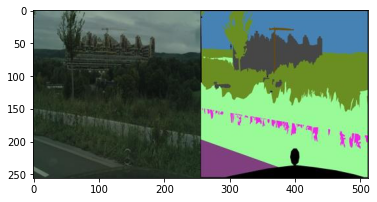

In [4]:
import matplotlib.pyplot as plt
a=plt.imread('cityscapes/train/153.jpg')
plt.imshow(a)
plt.show()

In [5]:
a.shape

(256, 512, 3)

이미지 데이터를 살펴보니, exploration에서 했던 pokemon 데이터와 거의 차이가 없습니다. sketch 대신 sematic segmentation이 주어져있다는 차이 정도입니다. 그리고 스케치 - 완성본이 있었는데, 원본 - semantic segmentation 순으로 순서가 바뀌어 있습니다. 그런데 색상별 label을 써먹을 수 있을까요? 잘 모르겠네요.  
일단 그냥 sketch2pokemon 에서 했던 것을 그대로 따라가봅니다.

In [6]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


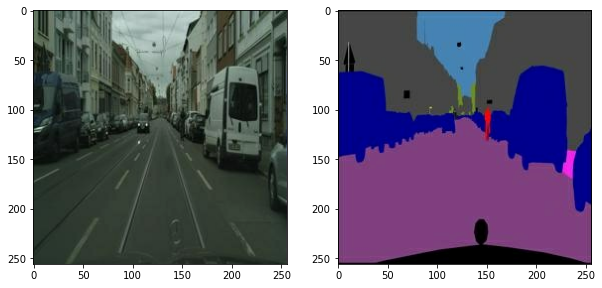

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    orig_img = img[:, :w, :] 
    orig_img = tf.cast(orig_img, tf.float32)
    seg = img[:, w:, :] 
    seg = tf.cast(seg, tf.float32)
    return normalize(orig_img), normalize(seg)

f = data_path + os.listdir(data_path)[1]
scape, segment = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(scape))
plt.subplot(1,2,2); plt.imshow(denormalize(segment))

# 1. Augmentation

In [8]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   


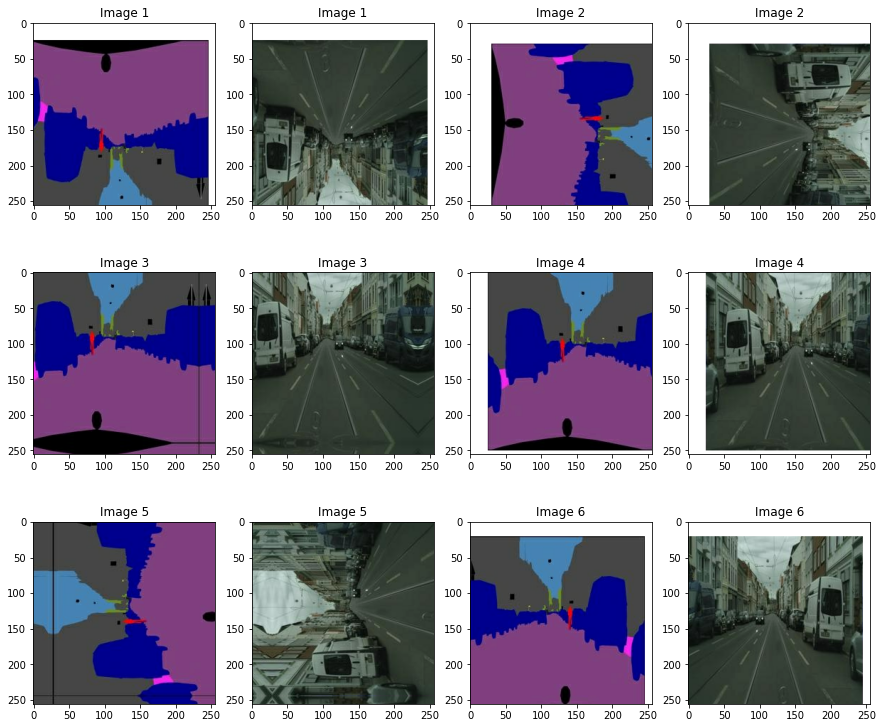

In [9]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_segment, augmented_scape = apply_augmentation(segment, scape)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_segment)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_scape)); plt.title(f"Image {img_n}")
    img_n += 1

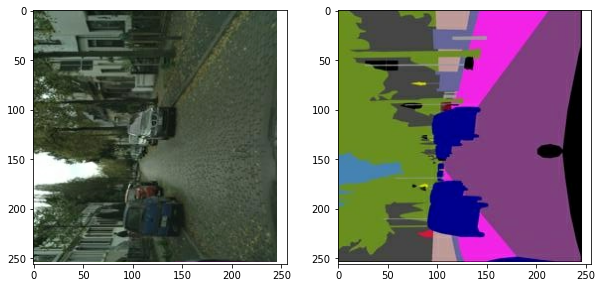

In [10]:
from tensorflow import data

def get_train(img_path):
    scape, segment = load_img(img_path)
    scape, segment = apply_augmentation(scape, segment)
    return scape, segment

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# 2. U-Net Generator 구현
이것도 그냥 따라갔습니다.

In [11]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [12]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [13]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)


class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()



In [14]:
UNetGenerator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_8 (EncodeBlock)    (None, 128, 128, 64) 3072        input_3[0][0]                    
__________________________________________________________________________________________________
encode_block_9 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block_8[0][0]             
__________________________________________________________________________________________________
encode_block_10 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_9[0][0]             
____________________________________________________________________________________________

In [15]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
Discriminator().get_summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_30 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________
Model: "model_4"
__________________________________________________________________________________________________
Lay

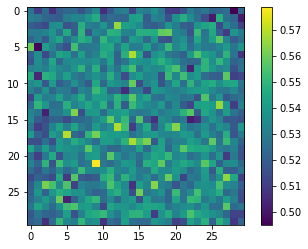

In [16]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [17]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss



In [18]:
EPOCHS = 120

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (scape, segment) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segment, scape) #sketch, colored 순으로 원래 넣었으니까 여기선 순서가 바뀌어야 합니다.
                
        # 100회 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

            



EPOCH[1] - STEP[100]                     
Generator_loss:1.5427                     
L1_loss:0.1864                     
Discriminator_loss:0.7962

EPOCH[1] - STEP[200]                     
Generator_loss:3.3122                     
L1_loss:0.1779                     
Discriminator_loss:1.2087

EPOCH[2] - STEP[100]                     
Generator_loss:2.0822                     
L1_loss:0.1744                     
Discriminator_loss:0.3375

EPOCH[2] - STEP[200]                     
Generator_loss:0.6089                     
L1_loss:0.2112                     
Discriminator_loss:1.8293

EPOCH[3] - STEP[100]                     
Generator_loss:1.2836                     
L1_loss:0.1617                     
Discriminator_loss:1.0820

EPOCH[3] - STEP[200]                     
Generator_loss:1.1007                     
L1_loss:0.1956                     
Discriminator_loss:0.6505

EPOCH[4] - STEP[100]                     
Generator_loss:2.0833                     
L1_loss:0.2212             

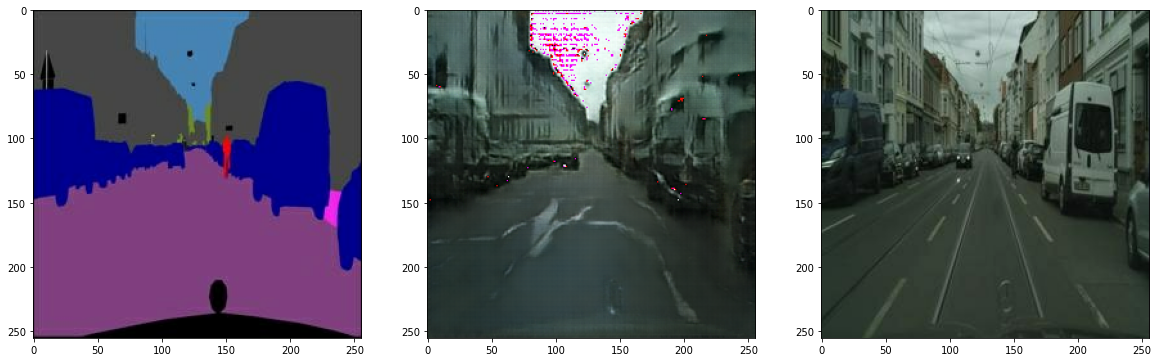

In [19]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
scape, segment = load_img(f)

pred = generator(tf.expand_dims(segment, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segment))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(scape))

# VAL 이미지로 테스트 & 시각화

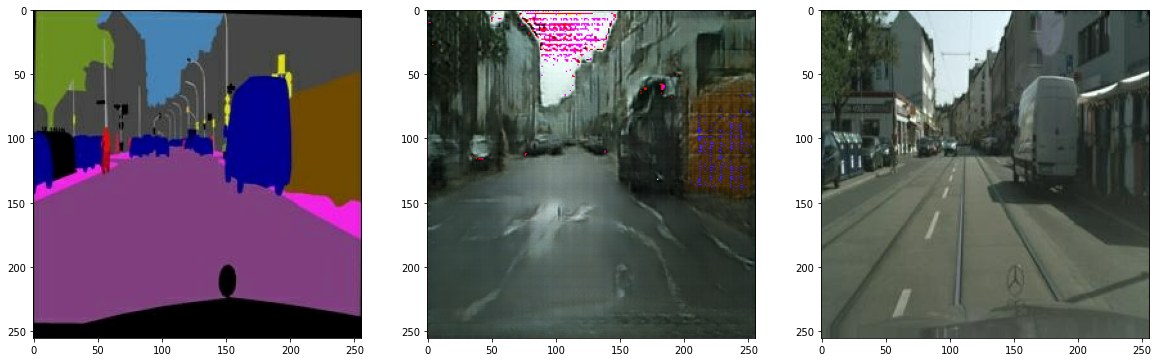

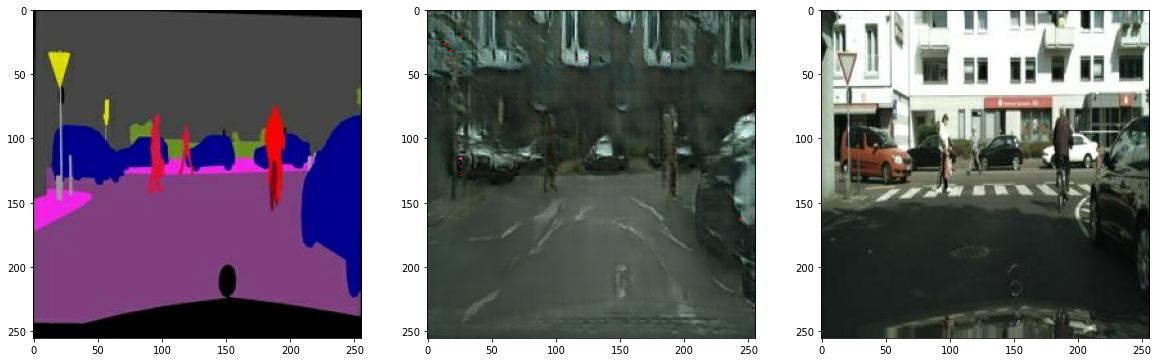

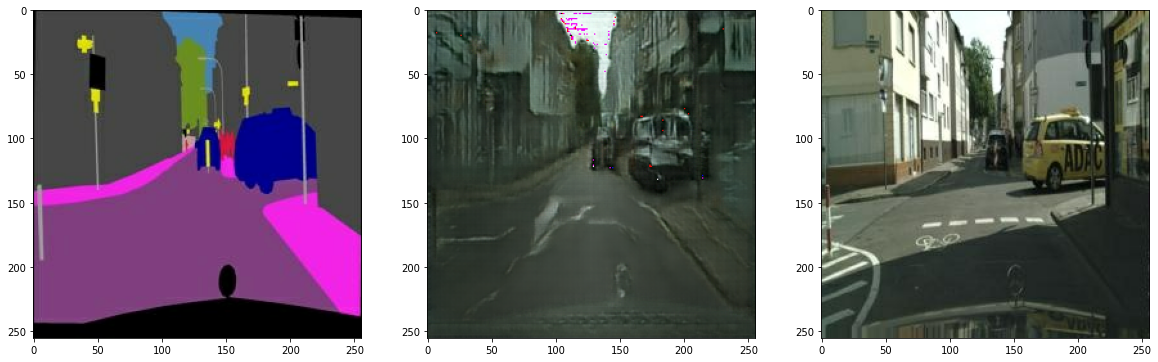

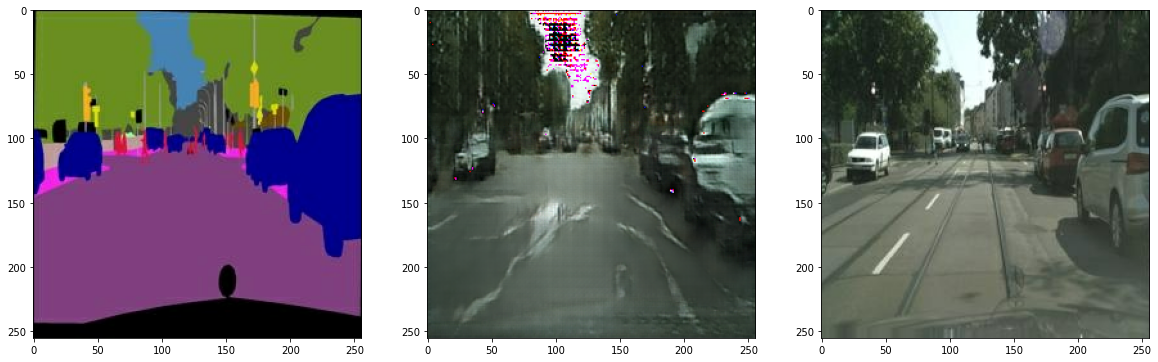

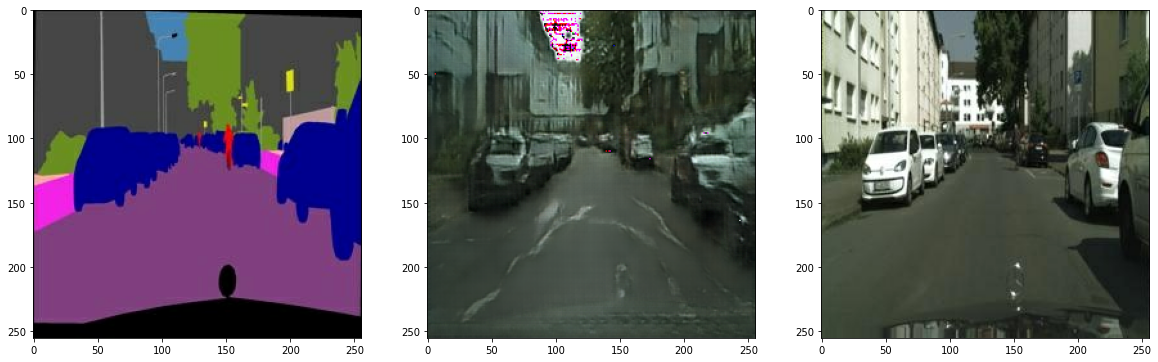

In [21]:
#val data에 의한 검증
val_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'

def validation(test_ind):

    f = val_path + os.listdir(val_path)[test_ind]
    scape, segment = load_img(f)

    pred = generator(tf.expand_dims(segment, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(segment))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(scape))
    plt.show()
    
for i in range(5):
    validation(i)

# Loss graph 그려보기
실수로 저장을 안해서 그냥 출력메시지에서 추출하겠습니다.
__text를 그냥 복붙합니다. 길어서 죄송합니다__

In [22]:
#text를 그냥 복붙합니다. 길어서 죄송합니다
text='''EPOCH[1] - STEP[100]                     
Generator_loss:1.5427                     
L1_loss:0.1864                     
Discriminator_loss:0.7962

EPOCH[1] - STEP[200]                     
Generator_loss:3.3122                     
L1_loss:0.1779                     
Discriminator_loss:1.2087

EPOCH[2] - STEP[100]                     
Generator_loss:2.0822                     
L1_loss:0.1744                     
Discriminator_loss:0.3375

EPOCH[2] - STEP[200]                     
Generator_loss:0.6089                     
L1_loss:0.2112                     
Discriminator_loss:1.8293

EPOCH[3] - STEP[100]                     
Generator_loss:1.2836                     
L1_loss:0.1617                     
Discriminator_loss:1.0820

EPOCH[3] - STEP[200]                     
Generator_loss:1.1007                     
L1_loss:0.1956                     
Discriminator_loss:0.6505

EPOCH[4] - STEP[100]                     
Generator_loss:2.0833                     
L1_loss:0.2212                     
Discriminator_loss:0.8709

EPOCH[4] - STEP[200]                     
Generator_loss:1.1458                     
L1_loss:0.1682                     
Discriminator_loss:0.5819

EPOCH[5] - STEP[100]                     
Generator_loss:1.0881                     
L1_loss:0.1857                     
Discriminator_loss:1.2071

EPOCH[5] - STEP[200]                     
Generator_loss:0.9651                     
L1_loss:0.1852                     
Discriminator_loss:0.6651

EPOCH[6] - STEP[100]                     
Generator_loss:0.6243                     
L1_loss:0.1881                     
Discriminator_loss:0.9106

EPOCH[6] - STEP[200]                     
Generator_loss:0.5182                     
L1_loss:0.1629                     
Discriminator_loss:1.4200

EPOCH[7] - STEP[100]                     
Generator_loss:0.8521                     
L1_loss:0.1994                     
Discriminator_loss:0.7676

EPOCH[7] - STEP[200]                     
Generator_loss:2.2785                     
L1_loss:0.1515                     
Discriminator_loss:1.9227

EPOCH[8] - STEP[100]                     
Generator_loss:2.9819                     
L1_loss:0.1553                     
Discriminator_loss:1.5080

EPOCH[8] - STEP[200]                     
Generator_loss:1.6003                     
L1_loss:0.1715                     
Discriminator_loss:0.9549

EPOCH[9] - STEP[100]                     
Generator_loss:0.4960                     
L1_loss:0.1913                     
Discriminator_loss:1.2840

EPOCH[9] - STEP[200]                     
Generator_loss:1.0268                     
L1_loss:0.1948                     
Discriminator_loss:0.7190

EPOCH[10] - STEP[100]                     
Generator_loss:0.8580                     
L1_loss:0.1720                     
Discriminator_loss:0.8471

EPOCH[10] - STEP[200]                     
Generator_loss:0.6586                     
L1_loss:0.1676                     
Discriminator_loss:1.0137

EPOCH[11] - STEP[100]                     
Generator_loss:1.3076                     
L1_loss:0.1808                     
Discriminator_loss:0.4373

EPOCH[11] - STEP[200]                     
Generator_loss:2.2102                     
L1_loss:0.1570                     
Discriminator_loss:1.0345

EPOCH[12] - STEP[100]                     
Generator_loss:2.1844                     
L1_loss:0.1799                     
Discriminator_loss:0.4171

EPOCH[12] - STEP[200]                     
Generator_loss:1.4045                     
L1_loss:0.1549                     
Discriminator_loss:0.7236

EPOCH[13] - STEP[100]                     
Generator_loss:0.5024                     
L1_loss:0.2067                     
Discriminator_loss:1.1433

EPOCH[13] - STEP[200]                     
Generator_loss:0.8896                     
L1_loss:0.1892                     
Discriminator_loss:0.7173

EPOCH[14] - STEP[100]                     
Generator_loss:0.9170                     
L1_loss:0.1547                     
Discriminator_loss:0.9518

EPOCH[14] - STEP[200]                     
Generator_loss:1.7621                     
L1_loss:0.2002                     
Discriminator_loss:0.2959

EPOCH[15] - STEP[100]                     
Generator_loss:1.6073                     
L1_loss:0.1561                     
Discriminator_loss:1.1923

EPOCH[15] - STEP[200]                     
Generator_loss:0.8695                     
L1_loss:0.1876                     
Discriminator_loss:0.9020

EPOCH[16] - STEP[100]                     
Generator_loss:1.7413                     
L1_loss:0.1940                     
Discriminator_loss:0.3268

EPOCH[16] - STEP[200]                     
Generator_loss:2.0667                     
L1_loss:0.2192                     
Discriminator_loss:0.2135

EPOCH[17] - STEP[100]                     
Generator_loss:0.6946                     
L1_loss:0.1693                     
Discriminator_loss:1.2317

EPOCH[17] - STEP[200]                     
Generator_loss:2.0581                     
L1_loss:0.1748                     
Discriminator_loss:1.0770

EPOCH[18] - STEP[100]                     
Generator_loss:1.0303                     
L1_loss:0.1863                     
Discriminator_loss:0.8610

EPOCH[18] - STEP[200]                     
Generator_loss:0.5075                     
L1_loss:0.1624                     
Discriminator_loss:1.7798

EPOCH[19] - STEP[100]                     
Generator_loss:1.8901                     
L1_loss:0.2161                     
Discriminator_loss:0.2593

EPOCH[19] - STEP[200]                     
Generator_loss:1.2331                     
L1_loss:0.1725                     
Discriminator_loss:0.6725

EPOCH[20] - STEP[100]                     
Generator_loss:2.2633                     
L1_loss:0.1780                     
Discriminator_loss:0.7493

EPOCH[20] - STEP[200]                     
Generator_loss:0.7487                     
L1_loss:0.1698                     
Discriminator_loss:1.0096

EPOCH[21] - STEP[100]                     
Generator_loss:1.4743                     
L1_loss:0.1654                     
Discriminator_loss:0.7216

EPOCH[21] - STEP[200]                     
Generator_loss:0.8751                     
L1_loss:0.1616                     
Discriminator_loss:1.1201

EPOCH[22] - STEP[100]                     
Generator_loss:1.1923                     
L1_loss:0.1875                     
Discriminator_loss:0.5123

EPOCH[22] - STEP[200]                     
Generator_loss:1.7076                     
L1_loss:0.1681                     
Discriminator_loss:0.3364

EPOCH[23] - STEP[100]                     
Generator_loss:1.1738                     
L1_loss:0.1660                     
Discriminator_loss:0.6531

EPOCH[23] - STEP[200]                     
Generator_loss:0.5669                     
L1_loss:0.1722                     
Discriminator_loss:1.1051

EPOCH[24] - STEP[100]                     
Generator_loss:1.5402                     
L1_loss:0.1779                     
Discriminator_loss:1.1009

EPOCH[24] - STEP[200]                     
Generator_loss:1.6293                     
L1_loss:0.1775                     
Discriminator_loss:0.7643

EPOCH[25] - STEP[100]                     
Generator_loss:1.6353                     
L1_loss:0.1863                     
Discriminator_loss:0.8674

EPOCH[25] - STEP[200]                     
Generator_loss:2.5695                     
L1_loss:0.1666                     
Discriminator_loss:1.8704

EPOCH[26] - STEP[100]                     
Generator_loss:1.3215                     
L1_loss:0.2240                     
Discriminator_loss:0.4187

EPOCH[26] - STEP[200]                     
Generator_loss:0.7484                     
L1_loss:0.1863                     
Discriminator_loss:1.1535

EPOCH[27] - STEP[100]                     
Generator_loss:0.3761                     
L1_loss:0.1735                     
Discriminator_loss:1.3812

EPOCH[27] - STEP[200]                     
Generator_loss:1.3533                     
L1_loss:0.2123                     
Discriminator_loss:0.3713

EPOCH[28] - STEP[100]                     
Generator_loss:1.5371                     
L1_loss:0.1817                     
Discriminator_loss:2.0984

EPOCH[28] - STEP[200]                     
Generator_loss:1.6809                     
L1_loss:0.1698                     
Discriminator_loss:0.5412

EPOCH[29] - STEP[100]                     
Generator_loss:0.8981                     
L1_loss:0.1789                     
Discriminator_loss:0.6457

EPOCH[29] - STEP[200]                     
Generator_loss:1.5907                     
L1_loss:0.2004                     
Discriminator_loss:0.2930

EPOCH[30] - STEP[100]                     
Generator_loss:2.1202                     
L1_loss:0.1763                     
Discriminator_loss:0.2304

EPOCH[30] - STEP[200]                     
Generator_loss:2.1703                     
L1_loss:0.1878                     
Discriminator_loss:0.1666

EPOCH[31] - STEP[100]                     
Generator_loss:0.5660                     
L1_loss:0.1809                     
Discriminator_loss:1.2380

EPOCH[31] - STEP[200]                     
Generator_loss:1.0317                     
L1_loss:0.1913                     
Discriminator_loss:0.6246

EPOCH[32] - STEP[100]                     
Generator_loss:1.2872                     
L1_loss:0.1743                     
Discriminator_loss:1.1411

EPOCH[32] - STEP[200]                     
Generator_loss:0.7131                     
L1_loss:0.1737                     
Discriminator_loss:0.9694

EPOCH[33] - STEP[100]                     
Generator_loss:1.2458                     
L1_loss:0.1931                     
Discriminator_loss:0.4424

EPOCH[33] - STEP[200]                     
Generator_loss:2.3185                     
L1_loss:0.1680                     
Discriminator_loss:0.2831

EPOCH[34] - STEP[100]                     
Generator_loss:1.4694                     
L1_loss:0.2021                     
Discriminator_loss:0.4290

EPOCH[34] - STEP[200]                     
Generator_loss:1.3065                     
L1_loss:0.1671                     
Discriminator_loss:0.5117

EPOCH[35] - STEP[100]                     
Generator_loss:2.1114                     
L1_loss:0.1677                     
Discriminator_loss:0.6730

EPOCH[35] - STEP[200]                     
Generator_loss:2.0274                     
L1_loss:0.1638                     
Discriminator_loss:0.3575

EPOCH[36] - STEP[100]                     
Generator_loss:0.9809                     
L1_loss:0.1452                     
Discriminator_loss:0.9886

EPOCH[36] - STEP[200]                     
Generator_loss:1.1162                     
L1_loss:0.1813                     
Discriminator_loss:0.5825

EPOCH[37] - STEP[100]                     
Generator_loss:0.9146                     
L1_loss:0.1585                     
Discriminator_loss:1.9030

EPOCH[37] - STEP[200]                     
Generator_loss:1.8937                     
L1_loss:0.1779                     
Discriminator_loss:1.5798

EPOCH[38] - STEP[100]                     
Generator_loss:2.0351                     
L1_loss:0.1705                     
Discriminator_loss:0.8426

EPOCH[38] - STEP[200]                     
Generator_loss:0.8127                     
L1_loss:0.1757                     
Discriminator_loss:0.7078

EPOCH[39] - STEP[100]                     
Generator_loss:1.1051                     
L1_loss:0.1413                     
Discriminator_loss:1.6114

EPOCH[39] - STEP[200]                     
Generator_loss:0.7127                     
L1_loss:0.1714                     
Discriminator_loss:1.5901

EPOCH[40] - STEP[100]                     
Generator_loss:1.4156                     
L1_loss:0.1963                     
Discriminator_loss:0.4269

EPOCH[40] - STEP[200]                     
Generator_loss:2.5410                     
L1_loss:0.1657                     
Discriminator_loss:1.6978

EPOCH[41] - STEP[100]                     
Generator_loss:1.4256                     
L1_loss:0.1855                     
Discriminator_loss:0.6655

EPOCH[41] - STEP[200]                     
Generator_loss:1.7941                     
L1_loss:0.1759                     
Discriminator_loss:0.5378

EPOCH[42] - STEP[100]                     
Generator_loss:0.7660                     
L1_loss:0.1723                     
Discriminator_loss:0.7716

EPOCH[42] - STEP[200]                     
Generator_loss:0.8216                     
L1_loss:0.1620                     
Discriminator_loss:1.0391

EPOCH[43] - STEP[100]                     
Generator_loss:1.6660                     
L1_loss:0.1621                     
Discriminator_loss:1.7564

EPOCH[43] - STEP[200]                     
Generator_loss:2.1472                     
L1_loss:0.1597                     
Discriminator_loss:0.7755

EPOCH[44] - STEP[100]                     
Generator_loss:1.2999                     
L1_loss:0.1667                     
Discriminator_loss:0.5758

EPOCH[44] - STEP[200]                     
Generator_loss:1.5284                     
L1_loss:0.2167                     
Discriminator_loss:0.3158

EPOCH[45] - STEP[100]                     
Generator_loss:1.5273                     
L1_loss:0.2203                     
Discriminator_loss:0.2949

EPOCH[45] - STEP[200]                     
Generator_loss:0.6511                     
L1_loss:0.1922                     
Discriminator_loss:0.8865

EPOCH[46] - STEP[100]                     
Generator_loss:1.6906                     
L1_loss:0.1527                     
Discriminator_loss:1.6335

EPOCH[46] - STEP[200]                     
Generator_loss:1.2894                     
L1_loss:0.2086                     
Discriminator_loss:0.4275

EPOCH[47] - STEP[100]                     
Generator_loss:0.6079                     
L1_loss:0.2215                     
Discriminator_loss:1.0625

EPOCH[47] - STEP[200]                     
Generator_loss:2.3284                     
L1_loss:0.1666                     
Discriminator_loss:1.0600

EPOCH[48] - STEP[100]                     
Generator_loss:1.4971                     
L1_loss:0.1656                     
Discriminator_loss:0.7571

EPOCH[48] - STEP[200]                     
Generator_loss:1.5236                     
L1_loss:0.1621                     
Discriminator_loss:1.4102

EPOCH[49] - STEP[100]                     
Generator_loss:0.9021                     
L1_loss:0.2080                     
Discriminator_loss:0.6262

EPOCH[49] - STEP[200]                     
Generator_loss:1.7285                     
L1_loss:0.1474                     
Discriminator_loss:1.1315

EPOCH[50] - STEP[100]                     
Generator_loss:1.7532                     
L1_loss:0.1857                     
Discriminator_loss:1.2078

EPOCH[50] - STEP[200]                     
Generator_loss:0.4109                     
L1_loss:0.1612                     
Discriminator_loss:1.4047

EPOCH[51] - STEP[100]                     
Generator_loss:1.4335                     
L1_loss:0.1481                     
Discriminator_loss:1.2911

EPOCH[51] - STEP[200]                     
Generator_loss:0.7071                     
L1_loss:0.1636                     
Discriminator_loss:0.9154

EPOCH[52] - STEP[100]                     
Generator_loss:1.0764                     
L1_loss:0.1815                     
Discriminator_loss:0.7923

EPOCH[52] - STEP[200]                     
Generator_loss:2.3475                     
L1_loss:0.1792                     
Discriminator_loss:0.5341

EPOCH[53] - STEP[100]                     
Generator_loss:1.4193                     
L1_loss:0.1512                     
Discriminator_loss:0.7904

EPOCH[53] - STEP[200]                     
Generator_loss:1.5119                     
L1_loss:0.2137                     
Discriminator_loss:0.3653

EPOCH[54] - STEP[100]                     
Generator_loss:1.9724                     
L1_loss:0.1665                     
Discriminator_loss:2.8523

EPOCH[54] - STEP[200]                     
Generator_loss:1.3349                     
L1_loss:0.1799                     
Discriminator_loss:1.3167

EPOCH[55] - STEP[100]                     
Generator_loss:0.8007                     
L1_loss:0.1690                     
Discriminator_loss:0.8557

EPOCH[55] - STEP[200]                     
Generator_loss:1.5112                     
L1_loss:0.1688                     
Discriminator_loss:0.3447

EPOCH[56] - STEP[100]                     
Generator_loss:1.8297                     
L1_loss:0.1544                     
Discriminator_loss:1.1621

EPOCH[56] - STEP[200]                     
Generator_loss:0.4630                     
L1_loss:0.2018                     
Discriminator_loss:1.8928

EPOCH[57] - STEP[100]                     
Generator_loss:0.3802                     
L1_loss:0.2040                     
Discriminator_loss:1.3222

EPOCH[57] - STEP[200]                     
Generator_loss:1.0674                     
L1_loss:0.1571                     
Discriminator_loss:1.6217

EPOCH[58] - STEP[100]                     
Generator_loss:1.3518                     
L1_loss:0.1639                     
Discriminator_loss:1.0999

EPOCH[58] - STEP[200]                     
Generator_loss:1.9248                     
L1_loss:0.1569                     
Discriminator_loss:0.6493

EPOCH[59] - STEP[100]                     
Generator_loss:0.9868                     
L1_loss:0.1615                     
Discriminator_loss:1.6715

EPOCH[59] - STEP[200]                     
Generator_loss:0.8022                     
L1_loss:0.1977                     
Discriminator_loss:0.8884

EPOCH[60] - STEP[100]                     
Generator_loss:2.8306                     
L1_loss:0.1774                     
Discriminator_loss:3.0546

EPOCH[60] - STEP[200]                     
Generator_loss:0.9751                     
L1_loss:0.1715                     
Discriminator_loss:0.8139

EPOCH[61] - STEP[100]                     
Generator_loss:1.0247                     
L1_loss:0.1629                     
Discriminator_loss:1.2457

EPOCH[61] - STEP[200]                     
Generator_loss:1.3810                     
L1_loss:0.1637                     
Discriminator_loss:2.0675

EPOCH[62] - STEP[100]                     
Generator_loss:1.7278                     
L1_loss:0.1529                     
Discriminator_loss:0.8621

EPOCH[62] - STEP[200]                     
Generator_loss:1.3112                     
L1_loss:0.1808                     
Discriminator_loss:0.4944

EPOCH[63] - STEP[100]                     
Generator_loss:1.5555                     
L1_loss:0.1672                     
Discriminator_loss:1.9323

EPOCH[63] - STEP[200]                     
Generator_loss:1.6422                     
L1_loss:0.1693                     
Discriminator_loss:0.2886

EPOCH[64] - STEP[100]                     
Generator_loss:1.1031                     
L1_loss:0.1537                     
Discriminator_loss:1.1433

EPOCH[64] - STEP[200]                     
Generator_loss:1.0165                     
L1_loss:0.1551                     
Discriminator_loss:0.7184

EPOCH[65] - STEP[100]                     
Generator_loss:1.3305                     
L1_loss:0.1827                     
Discriminator_loss:0.4688

EPOCH[65] - STEP[200]                     
Generator_loss:1.0247                     
L1_loss:0.1761                     
Discriminator_loss:0.9139

EPOCH[66] - STEP[100]                     
Generator_loss:2.3794                     
L1_loss:0.1650                     
Discriminator_loss:0.2848

EPOCH[66] - STEP[200]                     
Generator_loss:1.5375                     
L1_loss:0.1391                     
Discriminator_loss:1.9237

EPOCH[67] - STEP[100]                     
Generator_loss:1.9691                     
L1_loss:0.1594                     
Discriminator_loss:0.8190

EPOCH[67] - STEP[200]                     
Generator_loss:2.5398                     
L1_loss:0.1988                     
Discriminator_loss:0.1437

EPOCH[68] - STEP[100]                     
Generator_loss:1.3648                     
L1_loss:0.1928                     
Discriminator_loss:0.4763

EPOCH[68] - STEP[200]                     
Generator_loss:0.7194                     
L1_loss:0.1943                     
Discriminator_loss:0.8062

EPOCH[69] - STEP[100]                     
Generator_loss:1.1429                     
L1_loss:0.1653                     
Discriminator_loss:0.7315

EPOCH[69] - STEP[200]                     
Generator_loss:1.0865                     
L1_loss:0.1627                     
Discriminator_loss:0.5915

EPOCH[70] - STEP[100]                     
Generator_loss:1.6672                     
L1_loss:0.1766                     
Discriminator_loss:2.1220

EPOCH[70] - STEP[200]                     
Generator_loss:2.2653                     
L1_loss:0.1692                     
Discriminator_loss:1.3446

EPOCH[71] - STEP[100]                     
Generator_loss:1.6531                     
L1_loss:0.1966                     
Discriminator_loss:0.5960

EPOCH[71] - STEP[200]                     
Generator_loss:2.0379                     
L1_loss:0.1569                     
Discriminator_loss:0.6479

EPOCH[72] - STEP[100]                     
Generator_loss:1.1498                     
L1_loss:0.1377                     
Discriminator_loss:1.3579

EPOCH[72] - STEP[200]                     
Generator_loss:1.0945                     
L1_loss:0.1804                     
Discriminator_loss:0.7543

EPOCH[73] - STEP[100]                     
Generator_loss:1.2051                     
L1_loss:0.1941                     
Discriminator_loss:1.1679

EPOCH[73] - STEP[200]                     
Generator_loss:2.6547                     
L1_loss:0.1724                     
Discriminator_loss:0.5195

EPOCH[74] - STEP[100]                     
Generator_loss:0.6259                     
L1_loss:0.1896                     
Discriminator_loss:1.1097

EPOCH[74] - STEP[200]                     
Generator_loss:1.1266                     
L1_loss:0.1856                     
Discriminator_loss:2.2378

EPOCH[75] - STEP[100]                     
Generator_loss:0.6003                     
L1_loss:0.1790                     
Discriminator_loss:0.9734

EPOCH[75] - STEP[200]                     
Generator_loss:2.5116                     
L1_loss:0.2078                     
Discriminator_loss:0.1869

EPOCH[76] - STEP[100]                     
Generator_loss:1.9310                     
L1_loss:0.1907                     
Discriminator_loss:0.3444

EPOCH[76] - STEP[200]                     
Generator_loss:0.9803                     
L1_loss:0.1693                     
Discriminator_loss:0.7129

EPOCH[77] - STEP[100]                     
Generator_loss:0.7899                     
L1_loss:0.1524                     
Discriminator_loss:0.7892

EPOCH[77] - STEP[200]                     
Generator_loss:1.2989                     
L1_loss:0.1831                     
Discriminator_loss:0.5370

EPOCH[78] - STEP[100]                     
Generator_loss:0.2894                     
L1_loss:0.1554                     
Discriminator_loss:1.7280

EPOCH[78] - STEP[200]                     
Generator_loss:1.3910                     
L1_loss:0.1594                     
Discriminator_loss:0.5951

EPOCH[79] - STEP[100]                     
Generator_loss:1.8248                     
L1_loss:0.1421                     
Discriminator_loss:1.3845

EPOCH[79] - STEP[200]                     
Generator_loss:0.6983                     
L1_loss:0.1764                     
Discriminator_loss:1.2254

EPOCH[80] - STEP[100]                     
Generator_loss:1.7818                     
L1_loss:0.1821                     
Discriminator_loss:0.4483

EPOCH[80] - STEP[200]                     
Generator_loss:1.5867                     
L1_loss:0.1708                     
Discriminator_loss:0.4553

EPOCH[81] - STEP[100]                     
Generator_loss:0.6452                     
L1_loss:0.1941                     
Discriminator_loss:0.9564

EPOCH[81] - STEP[200]                     
Generator_loss:1.4024                     
L1_loss:0.1748                     
Discriminator_loss:0.5759

EPOCH[82] - STEP[100]                     
Generator_loss:2.1346                     
L1_loss:0.1654                     
Discriminator_loss:0.4935

EPOCH[82] - STEP[200]                     
Generator_loss:1.8960                     
L1_loss:0.1961                     
Discriminator_loss:0.4108

EPOCH[83] - STEP[100]                     
Generator_loss:1.4886                     
L1_loss:0.2068                     
Discriminator_loss:0.5122

EPOCH[83] - STEP[200]                     
Generator_loss:0.7700                     
L1_loss:0.1698                     
Discriminator_loss:1.2505

EPOCH[84] - STEP[100]                     
Generator_loss:1.1415                     
L1_loss:0.1627                     
Discriminator_loss:0.6918

EPOCH[84] - STEP[200]                     
Generator_loss:1.0485                     
L1_loss:0.1788                     
Discriminator_loss:0.5803

EPOCH[85] - STEP[100]                     
Generator_loss:1.4687                     
L1_loss:0.1837                     
Discriminator_loss:0.3543

EPOCH[85] - STEP[200]                     
Generator_loss:0.8546                     
L1_loss:0.1867                     
Discriminator_loss:0.6640

EPOCH[86] - STEP[100]                     
Generator_loss:1.9975                     
L1_loss:0.1892                     
Discriminator_loss:0.6156

EPOCH[86] - STEP[200]                     
Generator_loss:2.5914                     
L1_loss:0.1634                     
Discriminator_loss:1.2660

EPOCH[87] - STEP[100]                     
Generator_loss:1.2341                     
L1_loss:0.1892                     
Discriminator_loss:0.4023

EPOCH[87] - STEP[200]                     
Generator_loss:1.2788                     
L1_loss:0.1915                     
Discriminator_loss:0.4789

EPOCH[88] - STEP[100]                     
Generator_loss:2.4572                     
L1_loss:0.1807                     
Discriminator_loss:0.4234

EPOCH[88] - STEP[200]                     
Generator_loss:1.0593                     
L1_loss:0.1907                     
Discriminator_loss:0.6401

EPOCH[89] - STEP[100]                     
Generator_loss:1.7212                     
L1_loss:0.1805                     
Discriminator_loss:0.2732

EPOCH[89] - STEP[200]                     
Generator_loss:1.9924                     
L1_loss:0.1882                     
Discriminator_loss:0.2266

EPOCH[90] - STEP[100]                     
Generator_loss:1.6587                     
L1_loss:0.1780                     
Discriminator_loss:0.4300

EPOCH[90] - STEP[200]                     
Generator_loss:0.9967                     
L1_loss:0.1740                     
Discriminator_loss:0.7475

EPOCH[91] - STEP[100]                     
Generator_loss:1.5572                     
L1_loss:0.1594                     
Discriminator_loss:0.9853

EPOCH[91] - STEP[200]                     
Generator_loss:1.2049                     
L1_loss:0.2109                     
Discriminator_loss:0.4262

EPOCH[92] - STEP[100]                     
Generator_loss:3.2407                     
L1_loss:0.1588                     
Discriminator_loss:0.7887

EPOCH[92] - STEP[200]                     
Generator_loss:1.0861                     
L1_loss:0.1780                     
Discriminator_loss:0.5375

EPOCH[93] - STEP[100]                     
Generator_loss:1.4194                     
L1_loss:0.1909                     
Discriminator_loss:0.5452

EPOCH[93] - STEP[200]                     
Generator_loss:1.2184                     
L1_loss:0.1770                     
Discriminator_loss:0.4571

EPOCH[94] - STEP[100]                     
Generator_loss:0.7860                     
L1_loss:0.1939                     
Discriminator_loss:0.6864

EPOCH[94] - STEP[200]                     
Generator_loss:2.5284                     
L1_loss:0.1684                     
Discriminator_loss:0.7636

EPOCH[95] - STEP[100]                     
Generator_loss:0.0977                     
L1_loss:0.1885                     
Discriminator_loss:2.5809

EPOCH[95] - STEP[200]                     
Generator_loss:1.3411                     
L1_loss:0.1723                     
Discriminator_loss:0.8439

EPOCH[96] - STEP[100]                     
Generator_loss:1.2264                     
L1_loss:0.1872                     
Discriminator_loss:1.0600

EPOCH[96] - STEP[200]                     
Generator_loss:0.8663                     
L1_loss:0.1679                     
Discriminator_loss:0.8526

EPOCH[97] - STEP[100]                     
Generator_loss:1.8547                     
L1_loss:0.1591                     
Discriminator_loss:0.3525

EPOCH[97] - STEP[200]                     
Generator_loss:1.8679                     
L1_loss:0.2072                     
Discriminator_loss:0.2334

EPOCH[98] - STEP[100]                     
Generator_loss:2.3887                     
L1_loss:0.1525                     
Discriminator_loss:0.6924

EPOCH[98] - STEP[200]                     
Generator_loss:1.3796                     
L1_loss:0.2004                     
Discriminator_loss:0.3966

EPOCH[99] - STEP[100]                     
Generator_loss:1.3595                     
L1_loss:0.1856                     
Discriminator_loss:0.7505

EPOCH[99] - STEP[200]                     
Generator_loss:1.0156                     
L1_loss:0.1593                     
Discriminator_loss:1.2889

EPOCH[100] - STEP[100]                     
Generator_loss:2.7373                     
L1_loss:0.1678                     
Discriminator_loss:0.3897

EPOCH[100] - STEP[200]                     
Generator_loss:1.5148                     
L1_loss:0.1747                     
Discriminator_loss:0.4697

EPOCH[101] - STEP[100]                     
Generator_loss:2.4036                     
L1_loss:0.2106                     
Discriminator_loss:0.2629

EPOCH[101] - STEP[200]                     
Generator_loss:1.8726                     
L1_loss:0.1634                     
Discriminator_loss:2.3082

EPOCH[102] - STEP[100]                     
Generator_loss:1.5232                     
L1_loss:0.1854                     
Discriminator_loss:0.4584

EPOCH[102] - STEP[200]                     
Generator_loss:1.0379                     
L1_loss:0.1476                     
Discriminator_loss:1.6852

EPOCH[103] - STEP[100]                     
Generator_loss:2.8950                     
L1_loss:0.1725                     
Discriminator_loss:0.6946

EPOCH[103] - STEP[200]                     
Generator_loss:1.2137                     
L1_loss:0.1648                     
Discriminator_loss:1.8643

EPOCH[104] - STEP[100]                     
Generator_loss:1.1567                     
L1_loss:0.1760                     
Discriminator_loss:0.6099

EPOCH[104] - STEP[200]                     
Generator_loss:0.9092                     
L1_loss:0.2005                     
Discriminator_loss:1.0691

EPOCH[105] - STEP[100]                     
Generator_loss:3.0619                     
L1_loss:0.1583                     
Discriminator_loss:0.8998

EPOCH[105] - STEP[200]                     
Generator_loss:0.7202                     
L1_loss:0.1981                     
Discriminator_loss:0.9492

EPOCH[106] - STEP[100]                     
Generator_loss:1.0083                     
L1_loss:0.1551                     
Discriminator_loss:1.1467

EPOCH[106] - STEP[200]                     
Generator_loss:1.0478                     
L1_loss:0.1692                     
Discriminator_loss:1.0268

EPOCH[107] - STEP[100]                     
Generator_loss:1.6088                     
L1_loss:0.1446                     
Discriminator_loss:2.1713

EPOCH[107] - STEP[200]                     
Generator_loss:0.7548                     
L1_loss:0.1355                     
Discriminator_loss:0.9470

EPOCH[108] - STEP[100]                     
Generator_loss:1.6076                     
L1_loss:0.2040                     
Discriminator_loss:0.2800

EPOCH[108] - STEP[200]                     
Generator_loss:1.3088                     
L1_loss:0.1633                     
Discriminator_loss:0.8055

EPOCH[109] - STEP[100]                     
Generator_loss:0.4658                     
L1_loss:0.1769                     
Discriminator_loss:1.1993

EPOCH[109] - STEP[200]                     
Generator_loss:2.2620                     
L1_loss:0.1349                     
Discriminator_loss:1.5682

EPOCH[110] - STEP[100]                     
Generator_loss:0.7460                     
L1_loss:0.1796                     
Discriminator_loss:2.6289

EPOCH[110] - STEP[200]                     
Generator_loss:1.2928                     
L1_loss:0.1582                     
Discriminator_loss:0.5258

EPOCH[111] - STEP[100]                     
Generator_loss:1.1021                     
L1_loss:0.1752                     
Discriminator_loss:0.8006

EPOCH[111] - STEP[200]                     
Generator_loss:1.3762                     
L1_loss:0.1706                     
Discriminator_loss:0.6027

EPOCH[112] - STEP[100]                     
Generator_loss:1.5322                     
L1_loss:0.1739                     
Discriminator_loss:0.4194

EPOCH[112] - STEP[200]                     
Generator_loss:0.7389                     
L1_loss:0.1874                     
Discriminator_loss:0.7662

EPOCH[113] - STEP[100]                     
Generator_loss:1.8679                     
L1_loss:0.1663                     
Discriminator_loss:0.8199

EPOCH[113] - STEP[200]                     
Generator_loss:1.5485                     
L1_loss:0.1765                     
Discriminator_loss:0.8642

EPOCH[114] - STEP[100]                     
Generator_loss:1.1014                     
L1_loss:0.1557                     
Discriminator_loss:0.8097

EPOCH[114] - STEP[200]                     
Generator_loss:1.9161                     
L1_loss:0.1584                     
Discriminator_loss:0.4811

EPOCH[115] - STEP[100]                     
Generator_loss:2.4560                     
L1_loss:0.1561                     
Discriminator_loss:0.7610

EPOCH[115] - STEP[200]                     
Generator_loss:1.0193                     
L1_loss:0.1737                     
Discriminator_loss:0.6860

EPOCH[116] - STEP[100]                     
Generator_loss:1.2790                     
L1_loss:0.1675                     
Discriminator_loss:0.7429

EPOCH[116] - STEP[200]                     
Generator_loss:0.7305                     
L1_loss:0.1651                     
Discriminator_loss:1.9836

EPOCH[117] - STEP[100]                     
Generator_loss:2.1606                     
L1_loss:0.1574                     
Discriminator_loss:1.6273

EPOCH[117] - STEP[200]                     
Generator_loss:0.8123                     
L1_loss:0.1765                     
Discriminator_loss:0.9678

EPOCH[118] - STEP[100]                     
Generator_loss:2.0957                     
L1_loss:0.1848                     
Discriminator_loss:0.7425

EPOCH[118] - STEP[200]                     
Generator_loss:1.7462                     
L1_loss:0.1527                     
Discriminator_loss:0.8806

EPOCH[119] - STEP[100]                     
Generator_loss:1.6089                     
L1_loss:0.1711                     
Discriminator_loss:0.7449

EPOCH[119] - STEP[200]                     
Generator_loss:1.0813                     
L1_loss:0.1820                     
Discriminator_loss:0.5841

EPOCH[120] - STEP[100]                     
Generator_loss:0.3711                     
L1_loss:0.1554                     
Discriminator_loss:1.5735

EPOCH[120] - STEP[200]                     
Generator_loss:2.4040                     
L1_loss:0.1418                     
Discriminator_loss:0.6966'''

240 240 240


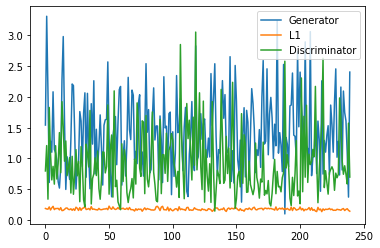

In [23]:
text=list(text.split('\n'))
generator_loss=[]
l1_loss=[]
discriminator_loss=[]
for line in text:
    _=line.replace(" ","")
    _=list(line.split(':'))
    if _[0]=='Generator_loss':
        generator_loss.append(float(_[1]))
    elif _[0]=='L1_loss':
        l1_loss.append(float(_[1]))
    elif _[0]=='Discriminator_loss':
        discriminator_loss.append(float(_[1]))
print(len(generator_loss), len(l1_loss), len(discriminator_loss)) #같은지 확인

plt.plot(generator_loss)
plt.plot(l1_loss)
plt.plot(discriminator_loss)
plt.legend(['Generator', 'L1', 'Discriminator'], loc='upper right')
plt.show()

# 돌아보기
어떻게 보면 그럴싸 한 것 같기도 하지만 이상한 그림이 나오네요. 논문에서 봤던 그럴싸한 이미지는 나오지 않았습니다만 보통 잘 나온 걸 보여주니까, validation용으로 여러 데이터를 적용하기 전에 잘 안됐다고 단정지을 필요는 없을 것 같습니다.